# Credit Risk Modelling - LGD & EAD Models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set the default style of the graphs to the seaborn style. 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics


from sklearn import linear_model
import scipy.stats as stat
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

import pickle

In [3]:
loan_data_preprocessed_backup = pd.read_csv('/content/drive/MyDrive/Credit Risk Modelling/loan_data_2007_2014_preprocessed.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Explore data

In [4]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

### Preprocessing - Independent Variables

In [5]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off',
                                                                                        'Does not meet the credit policy. Status:Charged Off'])]


In [6]:
loan_data_defaults.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis= 1, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Check for missing values

In [7]:
pd.options.display.max_rows = None

In [8]:
loan_data_defaults.isnull().sum()

id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                                         0
annual_inc                                         

In [9]:
# Fill the missing values for 'mths_since_last_delinq' and 'mths_since_last_record' with '0'
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace= True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Preprocessing - Dependent Variables

In [10]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt'] 
# create a new column 'recovery_rate'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
loan_data_defaults['recovery_rate'].describe()
# 'recovery rate' should be between 0 and 1

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
# replace 'recovery_rate' with 1 if values is greater than 1
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
# replace 'recovery_rate' with 0 if values is less than 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

In [14]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt']-loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']
# Credit Conversion Factor
loan_data_defaults['CCF'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [15]:
loan_data_defaults.to_csv('/content/drive/MyDrive/Credit Risk Modelling/loan_data_defaults.csv')
# save the dataframe to .csv

### Exploring the dependent variables

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

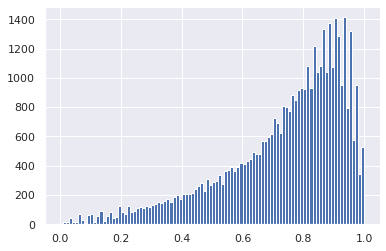

In [16]:
plt.hist(loan_data_defaults['CCF'], bins= 100)

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

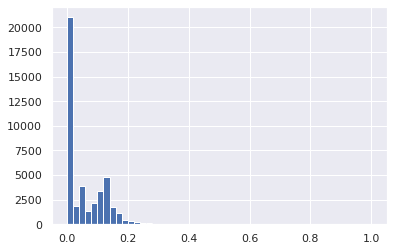

In [17]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

## LGD Model

Two step approach.
1. if 'recovery_rate' is equal to zero or not - `Logistic Regression`
2. if not zero, then calculate the value - `Linear Regression`

### Stage 1 - Logistic Regression

In [18]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1) # create a binary variable - 'recovery_rate_0_1' - value '0' if 'recovery_rate' is '0' else '1'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Splitting the data

In [19]:
loan_data_defaults.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'addr_state:VT', 'addr_state:WA', 'addr_state:WI', 'addr_state:WV',
       'addr_state:WY', 'initial_list_status:f', 'initial_list_status:w',
       'recovery_rate', 'CCF', 'recovery_rate_0_1'],
      dtype='object', length=209)

In [20]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis= 1), loan_data_defaults['recovery_rate_0_1'], test_size= 0.1, random_state= 42) 

In [21]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']
# List of the dummy variable reference categories. 

In [22]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
# keep the features needed for the model
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis =1)
# drop the reference categories

In [23]:
lgd_inputs_stage_1_train.isnull().sum()
# check for missing values

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

#### Estimating the Model

In [24]:
# p-values for sklearn logistic regression.
# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [25]:
# create instance
reg_lgd_st_1 = LogisticRegression_with_p_values()
# fit the data
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [26]:
feature_name = lgd_inputs_stage_1_train.columns.values # store the names of the columns of the dataframe in a variable.

In [27]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Creates a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_lgd_st_1.p_values # store p_values in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values)) # add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values 
# In the 'summary_table' dataframe, add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.402502e-04,NaN
1,grade:A,-3.396675e-05,9.996627e-01
2,grade:B,-1.569656e-04,9.980667e-01
3,grade:C,-2.587074e-04,9.966890e-01
4,grade:D,1.409176e-05,9.998266e-01
5,grade:E,3.633991e-05,9.995942e-01
6,grade:F,1.425201e-04,9.986164e-01
7,home_ownership:MORTGAGE,-8.344577e-05,9.972318e-01
8,home_ownership:NONE,1.891252e-06,9.999980e-01
9,home_ownership:OTHER,7.894225e-07,9.999985e-01


#### Testing the Model

In [28]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1) # remove the dummy variable reference categories
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test) # Calculate the predicted values for the dependent variable (targets)
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 1])

In [29]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test) # Calculate the predicted probability values for the dependent variable (targets)
y_hat_test_proba_lgd_stage_1

array([[0.42608387, 0.57391613],
       [0.3790345 , 0.6209655 ],
       [0.51724785, 0.48275215],
       ...,
       [0.41756587, 0.58243413],
       [0.49792166, 0.50207834],
       [0.37464342, 0.62535658]])

In [30]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1] # probabilities for being 1
y_hat_test_proba_lgd_stage_1

array([0.57391613, 0.6209655 , 0.48275215, ..., 0.58243413, 0.50207834,
       0.62535658])

In [31]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True) # reset the index of a dataframe

In [32]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1) # Concatenates two dataframes.
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index # Make the index of one dataframe equal to the index of another dataframe
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.573916
69814,1,0.620966
101396,0,0.482752
463268,1,0.533248
253729,0,0.417043


#### Estimating the Аccuracy of the Мodel

In [33]:
tr = 0.5
# create a new column, comapare observations with 'tr' if < tr assign 0, else assign 1
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [34]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a Confusion Matrix.

Predicted,0,1
Actual,,
0,718,1168
1,503,1935


In [35]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Receiver Operating Characteristic (ROC) Curve

Text(0.5, 1.0, 'ROC curve')

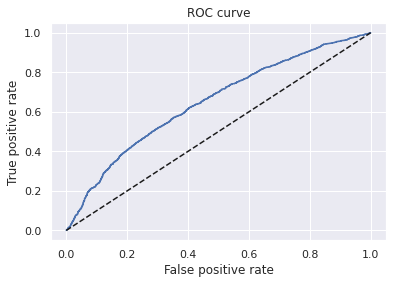

In [36]:
plt.plot(fpr, tpr)
# false positive rate along the x-axis and the true positive rate along the y-axis
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [37]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Area Under the Receiver Operating Characteristic Curve (AUROC)
AUROC

0.6485741402693479

#### Saving the Model

In [38]:
pickle.dump(reg_lgd_st_1, open('/content/drive/MyDrive/Credit Risk Modelling/lgd_model_stage_1.sav', 'wb')) # stage 1 model

### Stage 2 – Linear Regression

In [39]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]
# rows where indicator variable is equal to 1.

#### Splitting the data

In [40]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

#### Estimating the Model

In [41]:
# p-values for sklearn linear regression.
# Class to display p-values for linear regression in sklearn.
class Linear_Regression_with_pvalues(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(Linear_Regression_with_pvalues, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [42]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [43]:
reg_lgd_st_2 = Linear_Regression_with_pvalues()
# create an instance of an object from the 'LinearRegression' class
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train) # estimates the coefficients
feature_name = lgd_inputs_stage_2_train.columns.values
# names of the columns

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [44]:
# summary table
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


#### Evaluating the model

In [45]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [46]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test) # Calculatesthe predicted values for the dependent variable (targets)

In [47]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True) # reset the index of a dataframe.

In [48]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()
# correlation between actual and predicted values.

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


#### Saving the model

In [49]:
pickle.dump(reg_lgd_st_2, open('/content/drive/MyDrive/Credit Risk Modelling/lgd_model_stage_2.sav', 'wb'))

### Combining stage 1 & 2

In [50]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12669562, 0.10553345,
       0.098711  ])

In [51]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all # combine the predictions of the models from the two stages.
pd.DataFrame(y_hat_test_lgd).describe() # descriptive statisics

,0
count,4324.000000
mean,0.075348
std,0.052404
min,-0.007634
25%,0.000000
50%,0.093266
75%,0.115823
max,0.174821


In [52]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

pd.DataFrame(y_hat_test_lgd).describe() # descriptive statisics

,0
count,4324.000000
mean,0.075350
std,0.052401
min,0.000000
25%,0.000000
50%,0.093266
75%,0.115823
max,0.174821


## EAD Model

### Evaluation and Interpretation

In [53]:
# EAD model datasets
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Splits the data into training and tetsing dataset

In [54]:
ead_inputs_train.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

In [55]:
ead_inputs_train = ead_inputs_train[features_all] # keeping only the variables in 'features_all'
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1) # remove the dummy variable reference categories

### Estimating the model

In [56]:
reg_ead = Linear_Regression_with_pvalues() # create an instance
reg_ead.fit(ead_inputs_train, ead_targets_train) # Estimates the coefficients

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Linear_Regression_with_pvalues()

In [57]:
feature_name = ead_inputs_train.columns.values

In [58]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1 # Increase the index of every row of the dataframe with 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_] # Assign value of the row with index 0 of the dataframe
summary_table = summary_table.sort_index() 
# Sorts the dataframe by index.
p_values = reg_lgd_st_2.p # 'p_values'
p_values = np.append(np.nan,np.array(p_values)) # add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values 
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,1.970202e-12
5,grade:E,-6.768713e-02,1.918578e-03
6,grade:F,-2.045907e-02,2.748685e-01
7,home_ownership:MORTGAGE,-6.343341e-03,6.050271e-02
8,home_ownership:NONE,-5.539064e-03,9.092582e-05
9,home_ownership:OTHER,-2.426052e-03,6.436926e-01


### Model Validation

In [59]:
ead_inputs_test = ead_inputs_test[features_all] # keep only the variables needed for the model.
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1) # remove the dummy variable reference categories.
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [60]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test) # Calculates the predicted values

In [61]:
ead_targets_test_temp = ead_targets_test
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True) # reset the index of a dataframe

In [62]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr() # calculate the correlation between actual and predicted values

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


In [63]:
pd.DataFrame(y_hat_test_ead).describe() # descriptive statisics

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [64]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
# set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [65]:
pickle.dump(reg_lgd_st_2, open('/content/drive/MyDrive/Credit Risk Modelling/ead_model.sav', 'wb'))

# Expected Loss

`EL =  PD * LGD * EAD`

In [66]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,0,1,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,0,1,0
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,0,1,0
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,0,1,0


In [67]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)
# fill the missing values with zeroes.

In [68]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all] # keep only the variables needed for the model.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1) 
# remove the dummy variable reference categories. 

In [69]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)
# apply the stage 1 LGD model and calculate predicted values

loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)
# apply the stage 2 LGD model and calculate predicted values

loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
# combine the predicted values from the stage 1 predicted model and the stage 2 predicted model to calculate the final estimated recovery rate.

In [70]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])
# set estimated recovery rates that are greater than 1 to 1 and  estimated recovery rates that are less than 0 to 0.

In [71]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# calculate estimated LGD. Estimated LGD equals ' 1 - estimated recovery rate '

In [72]:
loan_data_preprocessed['LGD'].describe() # descriptive statisics

count    466285.000000
mean          0.931087
std           0.057899
min           0.357914
25%           0.880183
50%           0.911767
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [73]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)
# apply the EAD model to calculate estimated credit conversion factor

In [74]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])
# set estimated CCF that are greater than 1 to 1 and  estimated CCF that are less than 0 to 0.

In [75]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# calculate estimated EAD. Estimated EAD equals estimated CCF multiplied by funded amount.

In [76]:
loan_data_preprocessed['EAD'].describe() # descriptive statisics

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [77]:
# import data to apply the PD model.
loan_data_inputs_train = pd.read_csv('/content/drive/MyDrive/Credit Risk Modelling/loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('/content/drive/MyDrive/Credit Risk Modelling/loan_data_inputs_test.csv')

In [78]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0) # concatenate the two dataframes

In [79]:
loan_data_inputs_pd.shape

(466285, 325)

In [80]:
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [81]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
# set the index of the dataframe to 'Unnamed: 0'

In [82]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [83]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']

In [84]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [85]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd] # we keep only the variables needed for the model
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1) # remove the dummy variable reference categories
loan_data_inputs_pd_temp.shape

(466285, 84)

In [86]:
reg_pd = pickle.load(open('/content/drive/MyDrive/Credit Risk Modelling/pd_model.sav', 'rb')) # import the PD model, stored in the 'pd_model.sav' file

In [87]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# apply the PD model to caclulate estimated default probabilities

In [88]:
loan_data_inputs_pd['PD'].describe() # descriptive statisics

count    466285.000000
mean          0.109307
std           0.070916
min           0.007314
25%           0.056064
50%           0.093492
75%           0.146558
max           0.635804
Name: PD, dtype: float64

In [89]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1) # concatenate the dataframes with LGD, EAD and PD values

In [90]:
loan_data_preprocessed_new.shape

(466285, 539)

In [91]:
loan_data_preprocessed_new.to_csv('/content/drive/MyDrive/Credit Risk Modelling/loan_data_preprocessed_new.csv')